# First Application of Naive Bayes to Philosophy/Non-Philosophy Classification

In [1]:
import os
import pickle
from multiprocessing import Pool

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from nltk.corpus import stopwords

import numpy as np

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import pandas as pd

import NL_helpers

STOPWORDS = list(stopwords.words('english'))

## Load Labels and Corresponding Texts

Load labels with article codes.

In [2]:
annotated_df = pd.read_pickle('pickles/classified_df.pickle')

In [3]:
annotated_df

,Readable,Philosophy,Philosophy Type,Writing Type,NZ,Notes
LT_18971209_ARTICLE7,True,False,None,None,None,
NZTIM_18860722_ARTICLE11,True,False,None,None,None,
WC_18810721_ARTICLE7,True,False,None,None,None,
DUNST_18980513_ARTICLE3,True,False,None,None,None,
OAM_18960702_ARTICLE35,True,False,None,None,None,
...,...,...,...,...,...,...
AG_18840116_ARTICLE5,True,False,None,None,None,
MS_18830117_ARTICLE19,True,False,None,None,None,
GRA_18970305_ARTICLE3,True,False,None,None,None,
LT_18800611_ARTICLE5,True,False,None,None,None,


Use article codes to load texts.

In [4]:
dataset_path = '/home/joshua/hdd/Datasets/papers-past/'

The total dataset is divided into nine pickles. The following code runs through each, and collects the text for any articles in the annotated df using a left join opperation.

In [5]:
texts = pd.DataFrame(index=annotated_df.index)
for i in range(9):
    df = pd.read_pickle(dataset_path+f'corpus_df_{i}.tar.gz')
    matching_df = texts.join(df['Text'])
    annotated_df = annotated_df.combine_first(matching_df)
    del matching_df, df # May aid python memory management

Change text from list to simple string

In [6]:
annotated_df['Text as String'] = annotated_df['Text'].apply(NL_helpers.blocks2string)

In [7]:
annotated_df['Philosophy Type'].value_counts()

r    139
e     94
o     51
m     13
f      1
Name: Philosophy Type, dtype: int64

Drop non-philosophy.

In [8]:
annotated_df = annotated_df[annotated_df['Philosophy']==True]

In [9]:
annotated_df['Religion-Science'] = annotated_df['Philosophy Type'].apply(lambda x: (x == 'r'))

In [10]:
annotated_df['Religion-Science'].value_counts()

False    160
True     139
Name: Religion-Science, dtype: int64

Will take 75% of each class for the training dataset.

In [12]:
training_rel = annotated_df.loc[annotated_df['Religion-Science']==True].sample(n=139//4 * 3, random_state=1)
training_nonrel = annotated_df.loc[annotated_df['Religion-Science']==False].sample(n=160//4 * 3, random_state=1)
training_df = training_rel.append(training_nonrel)
del training_rel, training_nonrel

In [13]:
test_df = annotated_df.loc[[i for i in annotated_df.index if not i in training_df.index]]

In [14]:
test_df

,NZ,Notes,Philosophy,Philosophy Type,Readable,Text,Writing Type,Text as String,Religion-Science
LT_18941123_ARTICLE22,None,Theosophy,True,r,True,"[THE COMIN6 RACE., revealing to the world one ...",f,THE COMIN6 RACE.\nrevealing to the world one o...,True
WC_18791225_ARTICLE4,True,,True,r,True,[We notice that the editor of the Herald has b...,l,We notice that the editor of the Herald has be...,True
AS_18890605_ARTICLE27,True,"Final para, george grey ref to American idea o...",True,o,True,"[For tlio or ...u that laclsa assistance, For ...",f,"For tlio or ...u that laclsa assistance, For t...",False
NEM_18921228_ARTICLE44,None,,True,e,True,[(National Observer.) We begin by accepting mo...,f,(National Observer.) We begin by accepting mos...,False
HBT_18650904_ARTICLE11,None,Mention of phil books in library,True,o,True,"[t(OOD Woeds July, 1865 ; Sunday Magazine —Jul...",f,"t(OOD Woeds July, 1865 ; Sunday Magazine —July...",False
...,...,...,...,...,...,...,...,...,...
ODT_18820708_ARTICLE24,True,,True,r,True,"[TO THE EDITOB. Sir,—l am afraid ""Viator"" cann...",l,"TO THE EDITOB. Sir,—l am afraid ""Viator"" canno...",True
LT_18990211_ARTICLE29,None,,True,o,True,[Lv his “ Romance of the Earth ” Professor Bic...,r,Lv his “ Romance of the Earth ” Professor Bick...,False
DSC_18601207_ARTICLE27,None,,True,o,True,"[1 The^ meeting in London, under the Presidenc...",p,"1 The^ meeting in London, under the Presidency...",False
ESD_18760108_ARTICLE30,True,,True,o,True,"[The New Zealand Magazine, a quarterly Journal...",r,"The New Zealand Magazine, a quarterly Journal ...",False


In [15]:
training_df['Religion-Science'].value_counts()

False    120
True     102
Name: Religion-Science, dtype: int64

In [16]:
test_df['Religion-Science'].value_counts()

False    40
True     37
Name: Religion-Science, dtype: int64

## Set up Pipeline and Fit Model

Tokeniser change from default: words of length 3+ rather than 2+.

In [17]:
rel_classifier = Pipeline([
    ('vect', CountVectorizer(
        max_df=0.4,
        min_df=9,
        stop_words=STOPWORDS, 
        token_pattern=r'(?u)\b\w\w\w+\b')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [19]:
training_features = training_df['Text as String'].astype('string').to_numpy()

In [20]:
training_labels = training_df['Religion-Science'].to_numpy().astype(bool)

In [21]:
rel_classifier.fit(training_features, training_labels)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=9,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",...
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itse

In [23]:
test_features = test_df['Text as String'].astype('string').to_numpy()

In [24]:
test_labels = test_df['Religion-Science'].to_numpy().astype(bool)

In [26]:
predicted = rel_classifier.predict(test_features)

In [27]:
np.mean(predicted == test_labels)

0.8051948051948052

In [28]:
metrics.confusion_matrix(test_labels, predicted)

array([[34,  6],
       [ 9, 28]])

In [30]:
len(rel_classifier['vect'].vocabulary_)

2168

## Grid Parameter Search

In [57]:
parameters = {
    'vect__min_df': [2, 5, 7, 10],
    'vect__max_df': [0.3, 0.4, 0.5],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0.3, 0.4, 0.5, 0.75]
}

In [58]:
gs_clf = GridSearchCV(rel_classifier, parameters, cv=5, n_jobs=-1)
gs_clf.fit(training_features, training_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.4,
                                                        max_features=None,
                                                        min_df=9,
                                                        ngram_range=(1, 1),
                                                        prep

In [59]:
gs_clf.best_score_

0.8830303030303032

In [60]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.3
tfidf__use_idf: True
vect__max_df: 0.4
vect__min_df: 5
vect__ngram_range: (1, 1)


Allowing lower smoothing values helps with training performance, but not test.

In [61]:
predicted = gs_clf.best_estimator_.predict(test_features)

In [62]:
np.mean(predicted == test_labels)

0.8441558441558441

In [63]:
confusion_matrix = metrics.confusion_matrix(test_labels, predicted)
confusion_matrix

array([[34,  6],
       [ 6, 31]])

In [64]:
tp = confusion_matrix[1][1]
fn = confusion_matrix[1][0]
fp = confusion_matrix[0][1]
tn = confusion_matrix[0][0]
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'recall: {recall}')
print(f'precision: {precision}')

recall: 0.8378378378378378
precision: 0.8378378378378378


### Evaluation

Look at the false positives for overall accuracy model:

In [65]:
test_df['Predicted'] = predicted

In [66]:
false_negatives = test_df.loc[(test_df['Religion-Science'] == True)&(test_df['Predicted'] == False)]

In [67]:
false_negatives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Text,Writing Type,Text as String,Religion-Science,Predicted
LT_18941123_ARTICLE22,None,Theosophy,True,r,True,"[THE COMIN6 RACE., revealing to the world one ...",f,THE COMIN6 RACE.\nrevealing to the world one o...,True,False
OW_18920519_ARTICLE16,True,First letter only (change mid-block),True,r,True,[TO THE EDITOR. I S IR -Such is the title of t...,l,TO THE EDITOR. I S IR -Such is the title of th...,True,False
CHP_18750208_ARTICLE22,False,Final paragraph contains short arg that natura...,True,r,True,"[From a review in the Spectator of "" The Fores...",f,"From a review in the Spectator of "" The Forest...",True,False
AS_18940205_ARTICLE14,True,,True,r,True,"[For tlio cause that lacks ajsistanos, For tha...",f,"For tlio cause that lacks ajsistanos, For tha ...",True,False
NEM_18841119_ARTICLE13,None,theodicy,True,r,True,[: .-•;-. '■■--■?! ■ -'' ( Cotnmvwiiiciated.) ...,p,": .-•;-. '■■--■?! ■ -'' ( Cotnmvwiiiciated.) ""...",True,False
NZTIM_18871118_ARTICLE4,False,,True,r,True,[Atlantic Monthly. It has been deplored of lat...,f,Atlantic Monthly. It has been deplored of late...,True,False


In [68]:
def print_article_text(index, dataframe):
    print (f"{index}\n{dataframe.loc[index]['Text']}")
indices = false_negatives.index
interact(print_article_text, index=indices, dataframe=fixed(false_negatives))

interactive(children=(Dropdown(description='index', options=('LT_18941123_ARTICLE22', 'OW_18920519_ARTICLE16',…

<function __main__.print_article_text(index, dataframe)>

In [69]:
false_positives = test_df.loc[(test_df['Religion-Science'] == False)&(test_df['Predicted'] == True)]

In [70]:
false_positives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Text,Writing Type,Text as String,Religion-Science,Predicted
AS_18991106_ARTICLE6,None,,True,m,True,[Mr F. Davidson lectured last night in the Mut...,p,Mr F. Davidson lectured last night in the Mutu...,False,True
ESD_18891202_ARTICLE24,False,,True,m,True,"[. « The Bishop of Carlisle, who preached befo...",f,". « The Bishop of Carlisle, who preached befor...",False,True
ESD_18831020_ARTICLE32,False,A bit of anti-philosophy argument at the end,True,o,True,[At the request of a number of our readers we ...,r,At the request of a number of our readers we g...,False,True
WC_18750112_ARTICLE2,None,,True,m,True,[To some it may appear nothing short of an imp...,f,To some it may appear nothing short of an impe...,False,True
WCT_18731110_ARTICLE11,None,,True,o,True,[alh^ollowing lecture was delivered on Friday ...,p,alh^ollowing lecture was delivered on Friday n...,False,True
LT_18990211_ARTICLE29,None,,True,o,True,[Lv his “ Romance of the Earth ” Professor Bic...,r,Lv his “ Romance of the Earth ” Professor Bick...,False,True


In [71]:
indices = false_positives.index
interact(print_article_text, index=indices, dataframe=fixed(false_positives))

interactive(children=(Dropdown(description='index', options=('AS_18991106_ARTICLE6', 'ESD_18891202_ARTICLE24',…

<function __main__.print_article_text(index, dataframe)>

Well, we're at least distinguishing it from 'e'. In future work, most of 'm' would be rolled in to 'r' anyway.

In [72]:
with open('classifiers/religion-science_v2.pickle', 'wb') as fout:
    pickle.dump(gs_clf.best_estimator_, fout)

## Apply Model with Best Params to nb2 v2 subset.

In [99]:
# If necessary reload model:
with open('classifiers/religion-science.pickle', 'rb') as fin:
  rel_classifier = pickle.load(fin)

In [74]:
nb2_corpus = pd.read_pickle('pickles/nb2_philoso_df_v2.tar.gz')

In [75]:
nb2_corpus['Newspaper'] = nb2_corpus.index.map(lambda x: x[0:x.find('_')])
nb2_corpus['Date'] = nb2_corpus.index.map(lambda x: x[x.find('_')+1:x.find('_')+9])

In [76]:
nb2_corpus['Text as String'] = nb2_corpus['Text'].map(NL_helpers.blocks2string)
features = nb2_corpus['Text as String'].astype('string').to_numpy()

In [77]:
predictions = gs_clf.best_estimator_.predict(features)

In [78]:
len(predictions)

31131

In [79]:
len(features)

31131

In [80]:
nb2_corpus['Religion (pred)'] = predictions

In [81]:
rel_from_nb2 = nb2_corpus[nb2_corpus['Religion (pred)']==True]

In [82]:
rel_from_nb2

,Title,Text,Newspaper,Date,Text as String,Religion (pred)
LT_18940109_ARTICLE7,THE TASK OF THE BIOLOGIST.,[No. 11. When chemistry had finished _ shaping...,LT,18940109,No. 11. When chemistry had finished _ shaping;...,True
LT_18940115_ARTICLE5,THE THEORY OF EVOLUTION.,[SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' ...,LT,18940115,SIGNIFICANT RUDIMENTS. [BY W.G.P.] No. lII.' '...,True
LT_18940129_ARTICLE48,THE THEORY OF EVOLUTION.,[A CHANGED WORLD. [BY W.G.P.] No. V. The bitte...,LT,18940129,A CHANGED WORLD. [BY W.G.P.] No. V. The bitter...,True
LT_18940219_ARTICLE18,HERESY.,"[TO THE EDITOR. Sir,— The action of the Presby...",LT,18940219,"TO THE EDITOR. Sir,— The action of the Presbyt...",True
LT_18940219_ARTICLE24,REV JAMES GIBB ON CHRISTIAN DUTY.,"[At St Andrew’s Presbyterian Church, yesterday...",LT,18940219,"At St Andrew’s Presbyterian Church, yesterday ...",True
...,...,...,...,...,...,...
ODT_18771031_ARTICLE30,THE INDIAN FAMINE.,[TO THE TJDITOR. Sir—l think I have_ fair caus...,ODT,18771031,TO THE TJDITOR. Sir—l think I have_ fair cause...,True
ODT_18771107_ARTICLE32,POPULAR CULTURE.,"[The. discourse of Mi* J^hn M >r!ev on "" I'opu...",ODT,18771107,"The. discourse of Mi* J^hn M >r!ev on "" I'opul...",True
ODT_18790115_ARTICLE20,MR BRIGHT AND THE ELDERS. TO THE EDITOR.,"[Sib,—However objectionable Mr Bright's title ...",ODT,18790115,"Sib,—However objectionable Mr Bright's title m...",True
ODT_18790118_ARTICLE23,UNTITLED,"[Sir,—Before the public can fairly under stand...",ODT,18790118,"Sir,—Before the public can fairly under stand ...",True


No need to remove duplicates this time as they have already been removed from nb2 corpus.

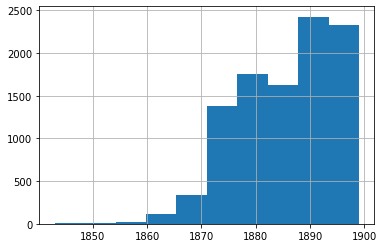

In [89]:
rel_from_nb2.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

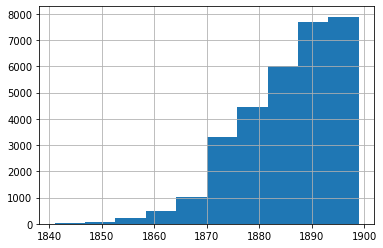

In [90]:
nb2_corpus.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

In [86]:
rel_from_nb2['Newspaper'].value_counts()

ODT        1163
ESD        1064
AS          879
OW          869
CHP         558
LT          467
NZTIM       425
BH          391
TC          344
HBH         320
NEM         298
WC          263
WH          242
DSC         234
NOT         226
OAM         221
DTN         211
MEX         158
WCT         138
WT          124
GRA         119
WSTAR       116
AG          110
CROMARG      90
LWM          89
MIC          85
WI           75
ME           75
FS           73
DUNST        58
WDT          53
WAIST        48
MT           38
MS           38
OO           37
WEST         32
WOODEX       31
IT           30
LCP          30
MH           30
HNS          28
BA           26
NA           21
CL           20
HBT          18
KUMAT        14
OG            8
HAST          7
OPUNT         7
NZSCSG        4
HLC           3
HBWT          1
WDA           1
NZCPNA        1
MTBM          1
ALG           1
Name: Newspaper, dtype: int64

In [87]:
nb2_corpus['Newspaper'].value_counts()

ODT        2867
ESD        2733
OW         2699
AS         2231
LT         2173
CHP        1881
BH         1594
NZTIM      1391
TC          986
NEM         849
HBH         831
DSC         763
OAM         710
NOT         661
MEX         583
WH          570
WSTAR       549
WC          545
DTN         527
WT          521
LWM         512
CROMARG     455
WCT         436
ME          386
GRA         385
AG          361
WI          289
WDT         248
MIC         230
FS          209
DUNST       162
IT          155
OO          149
WAIST       139
WEST        138
LCP         135
BA          124
HBT         123
CL          112
HNS         102
MH           96
MS           92
MT           75
WOODEX       74
NA           58
KUMAT        52
HAST         49
OG           32
NZSCSG       26
OPUNT        15
HLC          14
NZCPNA        8
HBWT          8
NZGWS         7
WDA           6
ALG           2
MTBM          2
CHARG         1
Name: Newspaper, dtype: int64

In [84]:
rel_from_nb2.to_pickle('pickles/rel_v2_philoso_df.tar.gz')